In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from ipywidgets import interact
import pymongo
import h5py
from sklearn.cluster import KMeans

In [21]:
def load_stacks(beamline : str , sample_name : str , scan_type : str):
    client = pymongo.MongoClient('mongodb://localhost/')
    db = client['in_situ_fluo']
    stack_coll = db['stacks']
    query = {}
    
    query['beamline'] = beamline
    
    query['sample_name'] = sample_name
    
    query['scan_type'] = scan_type
    stack_doc = stack_coll.find_one(query)
    element_names = ['Al_Ka', 'Mn_Ka', 'Cr_Ka']
    images = {}
    print(stack_doc['file_path'])
    with h5py.File(stack_doc['file_path'], 'r') as f:
        stack_group = f[f'/registered/line_intensities']
        
        for element in element_names:
            images[element] = stack_group[element][()]

        unix_time = f['/unregistered/unix_time'][()]
        mean_scan_times = np.nanmean(unix_time, axis=(1,2))
        hours = mean_scan_times/(60*60)
        hours = hours-hours[0]
    return images, hours


In [22]:
images, hours = load_stacks('P06', '08_alloy_C_lamella_A_roco', 'jmesh ROI2')


hours = np.arange(0,len(hours))

/data/lazari/data/chalmers_al_am/Al_AM_P06/process/08_alloy_C_lamella_A_roco/stacks/jmesh ROI2.h5


In [23]:

from matplotlib.patches import Rectangle
vmin =0
vmax = 200
col_roi = 40
row_roi = 130
box_width = 50
@interact(im_nr=(0,len(images['Mn_Ka'])-1, 1), element=images.keys(), vmin=(0,5000, 1), vmax=(10,5000,1),row_roi=(0, images['Mn_Ka'][0].shape[0], 1), col_roi=(0,images['Mn_Ka'][0].shape[1], 1), box_width=(0, images['Mn_Ka'][0].shape[0], 1))

def plot_im(im_nr, element, vmin , vmax, row_roi, col_roi, box_width):
    plt.figure(figsize=(8,8))
    plt.imshow(images[element][im_nr],vmin=vmin, vmax=vmax,cmap='hot', origin='upper')
    
    #plt.imshow(np.log(images[im_nr]), vmin=3,vmax=6.5)
    plt.title(f'{element}. t: {hours[im_nr]} h')
    plt.axis('off')
    ax = plt.gca()
    
    ax.add_patch(Rectangle((col_roi,row_roi), box_width,box_width, fill=False))
    

    
    plt.colorbar()

interactive(children=(IntSlider(value=11, description='im_nr', max=22), Dropdown(description='element', option…

In [24]:
crop_row = 13
crop_col = 2
box_width=78

In [25]:
#crop to exclude black areas
for element in images:
    images[element] = np.array(images[element])
    im = images[element][:, crop_row:crop_row+box_width, crop_col:crop_col+box_width]
    images[element] = im[0:-1] # remove last image which was corrupted
    


hours = hours[:-1]


In [26]:

@interact(im_nr=(0,len(images['Mn_Ka'])-1, 1), element=images.keys(), vmin=(0,1000, 1), vmax=(10,5000,1))

def plot_im(im_nr, element, vmin , vmax):
    plt.figure(figsize=(8,8))
    plt.imshow(images[element][im_nr],vmin=vmin, vmax=vmax,cmap='hot', origin='upper')
    
    #plt.imshow(np.log(images[im_nr]), vmin=3,vmax=6.5)
    #plt.title(f'{element}. t: {hours[im_nr]} h')
    plt.axis('off')
    
    

    
    plt.colorbar()

interactive(children=(IntSlider(value=10, description='im_nr', max=21), Dropdown(description='element', option…

In [27]:
images['Mn_Ka'].shape

(22, 78, 78)

In [30]:
def plot_pixel_time_series(time, data, name=None):
    import matplotlib as mpl
    data_shape =data.shape 
    if len(data_shape)>2:
        data = np.reshape(data, [data_shape[0], data_shape[1]*data_shape[2]])
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.plot(hours, data, alpha=0.01)
    plt.title('Pixel intensity of every pixel')
    plt.subplot(1,2,2)
    plt.plot(hours, data[:,::10], alpha=0.5)

    plt.title('Pixel intensity of every 10th pixel')
    plt.xlabel('t (h)')
    ax = plt.gca()
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    plt.ylabel('Intensity (a.u.)')
    if name:
        plt.suptitle(name)
    plt.show()




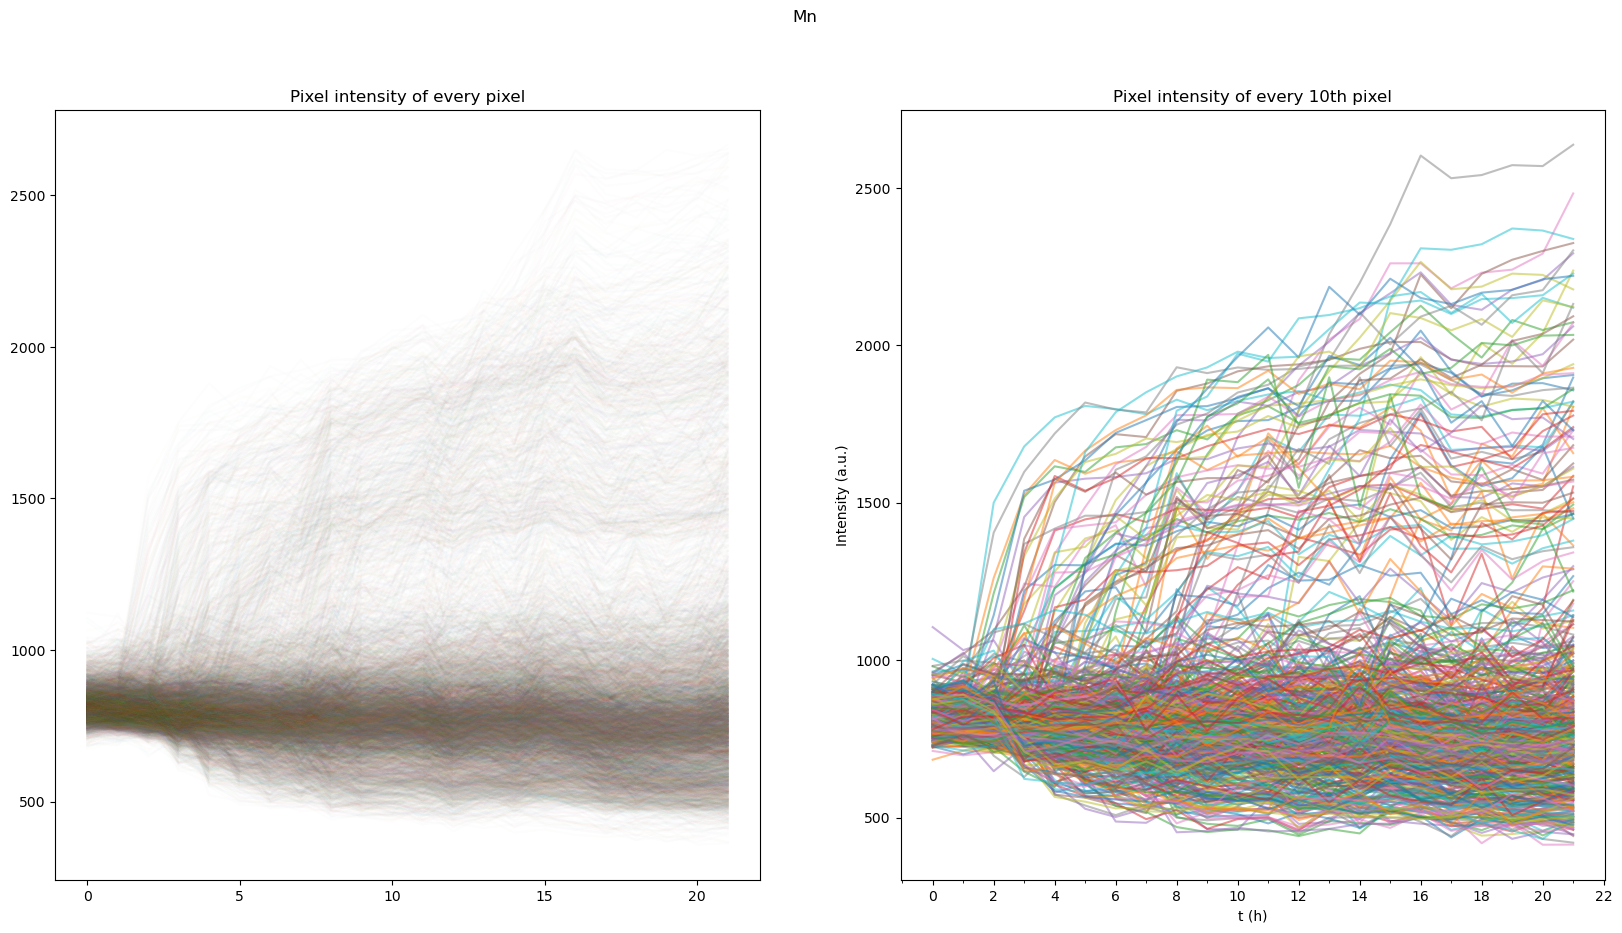

In [31]:

plot_pixel_time_series(hours, images['Mn_Ka'], 'Mn')

In [32]:
def smooth_time_series(data, window_size):
    data_shape =data.shape 
    if len(data_shape)>2:
        data = np.reshape(data, [data_shape[0], data_shape[1]*data_shape[2]])
    return pd.DataFrame(data).rolling(window=window_size).mean().to_numpy()

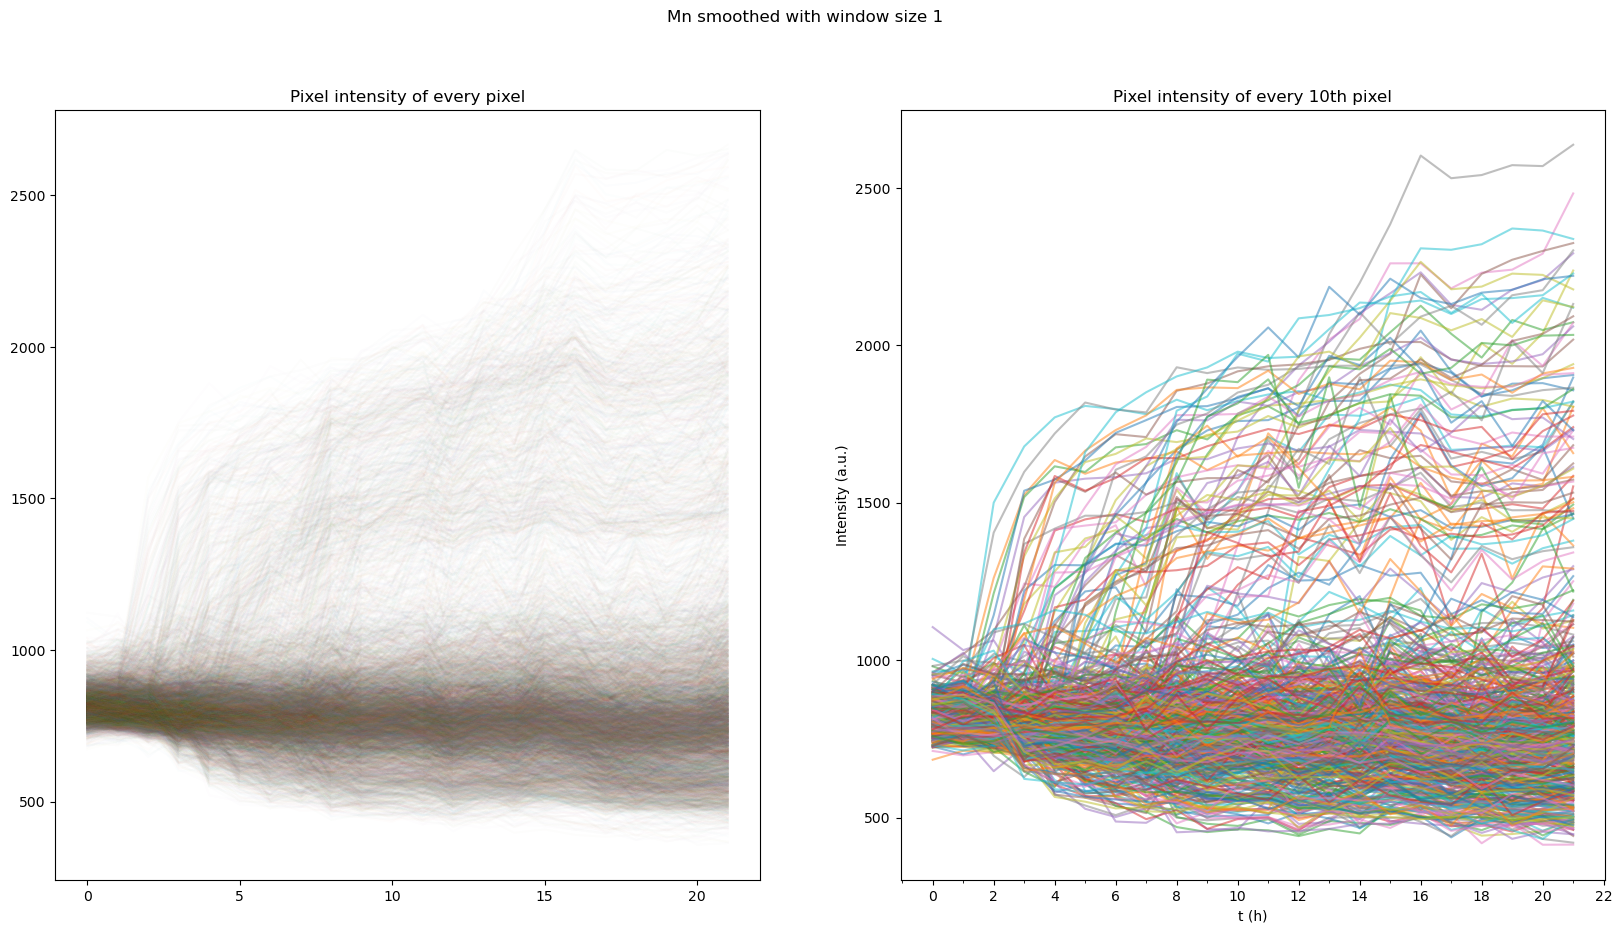

In [33]:
window_size =1
smoothed_Mn = smooth_time_series(images['Mn_Ka'], window_size)
plot_pixel_time_series(hours, smoothed_Mn, f'Mn smoothed with window size {window_size}')

In [34]:

from sklearn.metrics import silhouette_score

range_to_test = np.arange(2,20)
for n_clusters in range_to_test:
    
    
    model = KMeans(n_clusters=n_clusters)
    model.fit(smoothed_Mn.T[:,window_size-1:])
    cluster_labels = model.labels_
    # Calculate the silhouette score of the clustering
    silhouette_avg = silhouette_score(smoothed_Mn.T[:,window_size-1:], cluster_labels)
    print(f'Sillhuette for {n_clusters} clusters: {silhouette_avg}')


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 2 clusters: 0.7614358652440973


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 3 clusters: 0.40985590470593997


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


Sillhuette for 4 clusters: 0.36340319418411976


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 5 clusters: 0.3256973047415275


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 6 clusters: 0.32953500406498487


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 7 clusters: 0.2914886454054145


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 8 clusters: 0.2730966353096513


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 9 clusters: 0.2764136795284783


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 10 clusters: 0.24301038868558358


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 11 clusters: 0.25032409134860756


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 12 clusters: 0.242599250072011


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 13 clusters: 0.24857048319906103


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 14 clusters: 0.24179893846580386


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 15 clusters: 0.23242683353056434


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 16 clusters: 0.2069317856256743


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 17 clusters: 0.2037716041290965


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 18 clusters: 0.20280283629840137


/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sillhuette for 19 clusters: 0.19913705137126558


In [35]:
n_clusters = 9
Mn_cluster_model = KMeans(n_clusters=n_clusters)
Mn_cluster_model.fit(smoothed_Mn.T[:,window_size-1:])

/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=9)

In [36]:
def plot_cluster_results(model, hours, data_shape, name=None):
    from matplotlib import cm
    import matplotlib.colors as colors
    import matplotlib as mpl
    cmap_ = cm.Set1_r
   
    # Define the normalization for the colormap
    norm = colors.Normalize(vmin=0, vmax=model.labels_.max())
    # Map the cluster labels to colors using the colormap and normalization
    cluster_colors = cmap_(norm(model.labels_.reshape([data_shape[0], data_shape[1]])))
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(cluster_colors, cmap=cmap_)
    plt.title('Cluster labels')

    plt.subplot(1,2,2)

    for idx,center in enumerate(model.cluster_centers_):
        plt.plot(hours[window_size-1:], center.T, label=f'Cluster {idx}', color=cmap_(norm(idx)), linewidth=4)
    plt.xlabel('t (h)')
    plt.title('Cluster mean')
    ax = plt.gca()
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    if name:
        plt.suptitle(name)
    plt.legend()


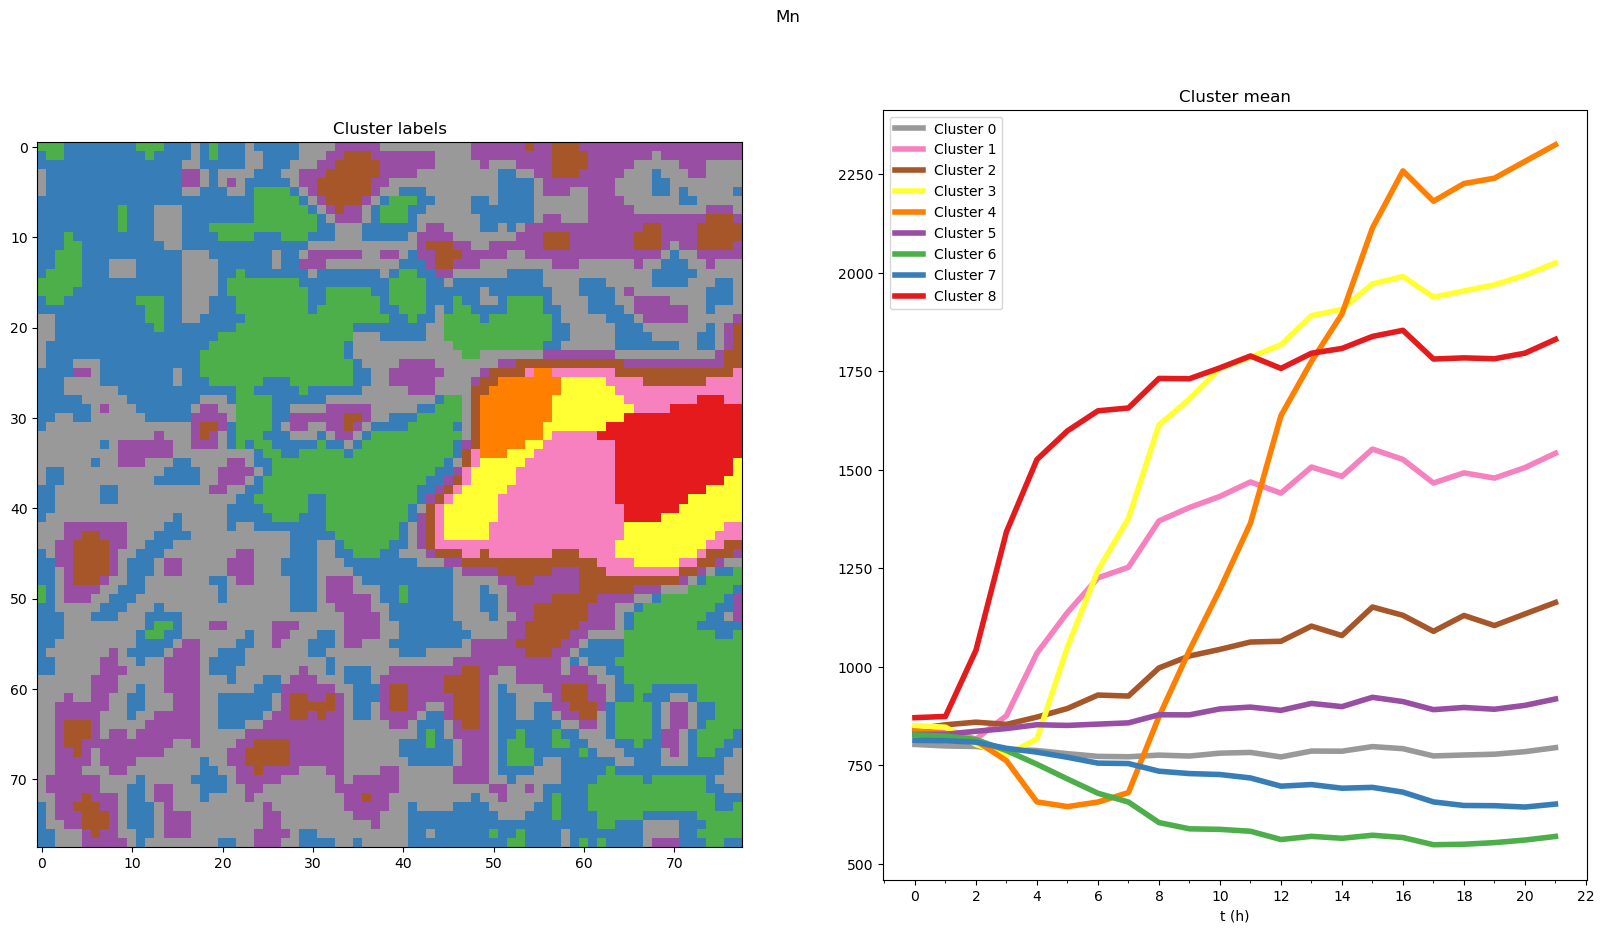

In [37]:
plot_cluster_results(Mn_cluster_model, hours, images['Mn_Ka'][0].shape, 'Mn')

# Cr clustering

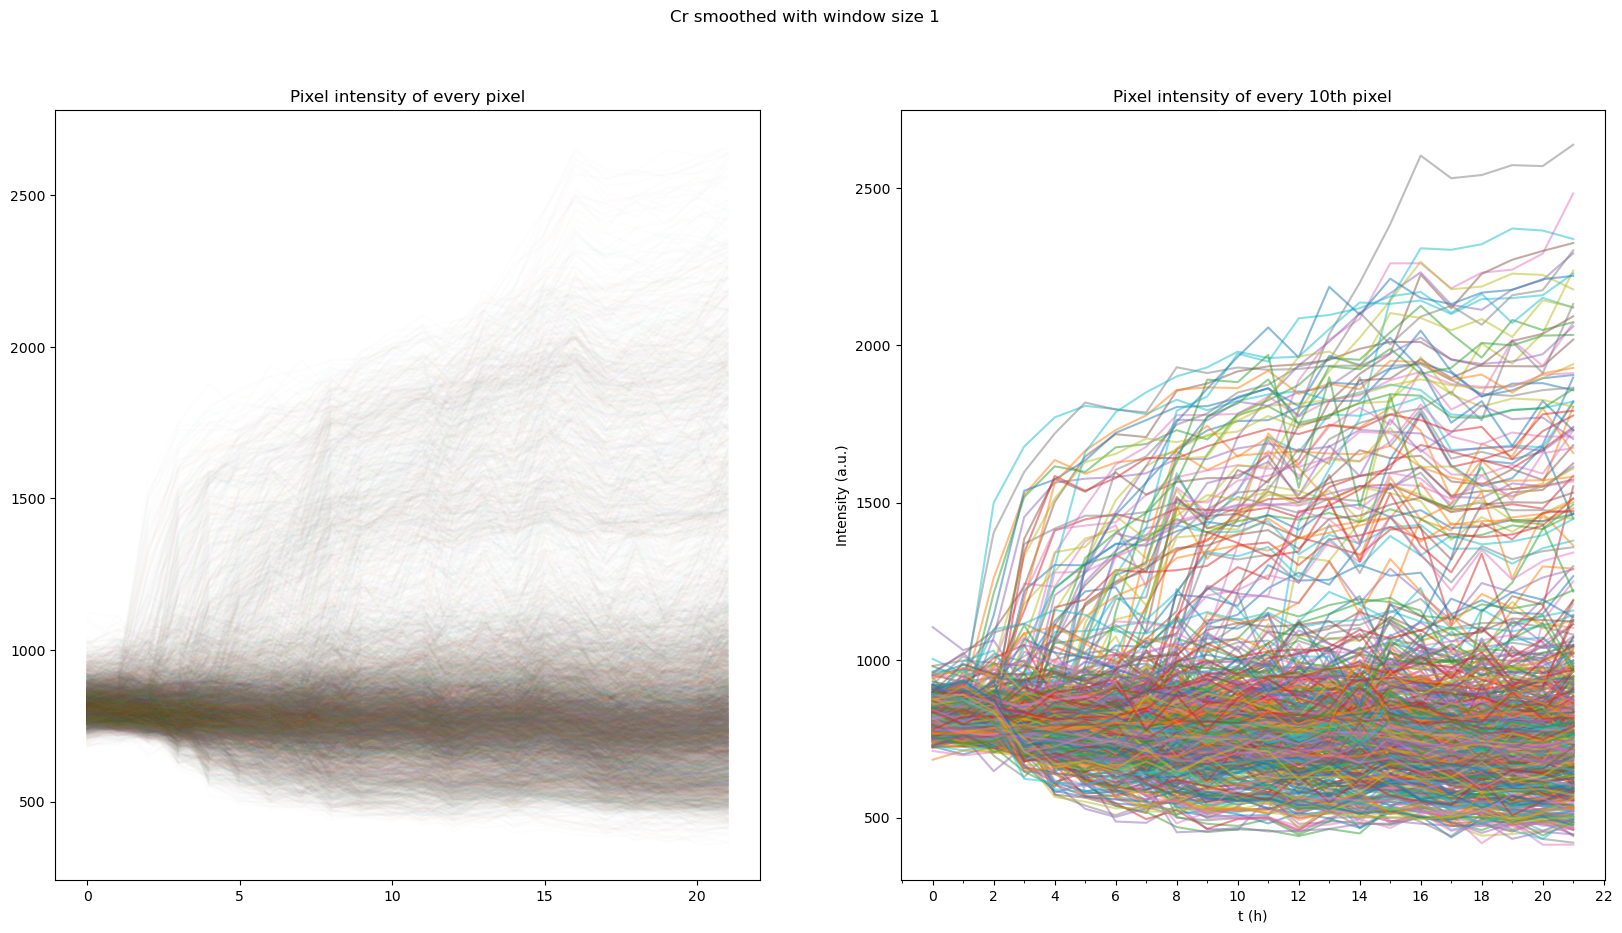

In [38]:
window_size =1
smoothed_Cr = smooth_time_series(images['Cr_Ka'], window_size)
plot_pixel_time_series(hours, smoothed_Mn, f'Cr smoothed with window size {window_size}')

In [41]:
n_clusters = 9
Cr_cluster_model = KMeans(n_clusters=n_clusters)
Cr_cluster_model.fit(smoothed_Cr.T[:,window_size-1:])

/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=9)

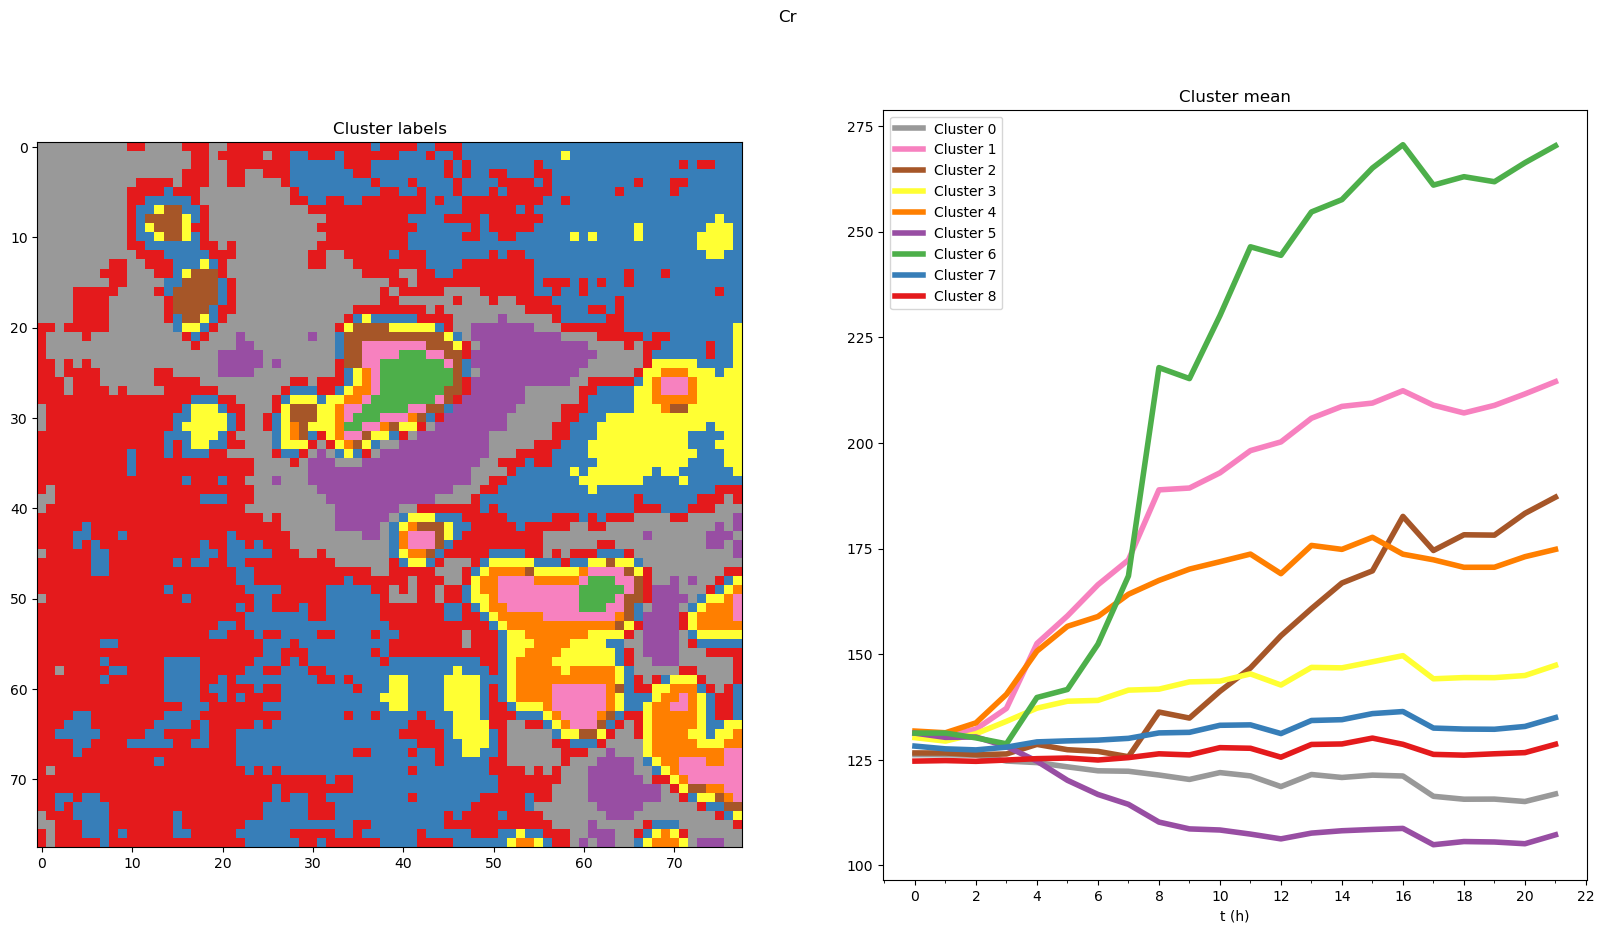

In [42]:
plot_cluster_results(Cr_cluster_model, hours, images['Cr_Ka'][0].shape, 'Cr')

# Clustering Cr/Mn fractions 

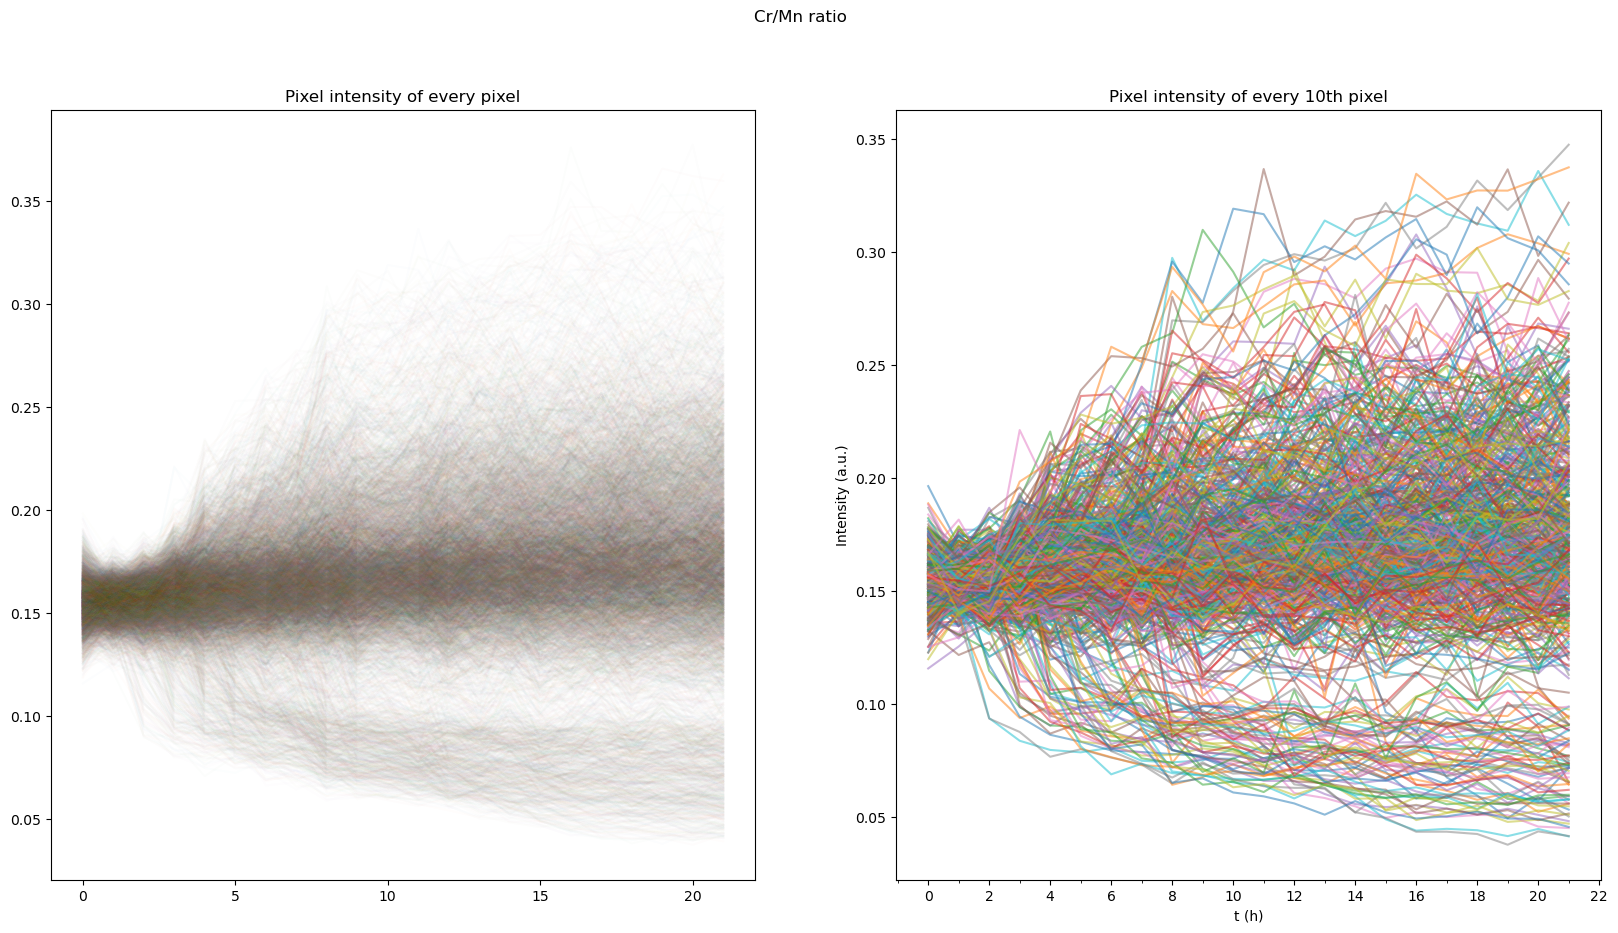

In [43]:
Cr_to_Mn = images['Cr_Ka']/images['Mn_Ka']
plot_pixel_time_series(hours, Cr_to_Mn, 'Cr/Mn ratio')

In [44]:
window_size = 1
smoothed_Cr_to_Mn = smooth_time_series(Cr_to_Mn, window_size)
n_clusters = 9
Cr_Mn_cluster_model = KMeans(n_clusters=n_clusters)
Cr_Mn_cluster_model.fit(smoothed_Cr_to_Mn.T[:,window_size-1:])

/data/lazari/Software/conda/envs/chalmers_al_am/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=9)

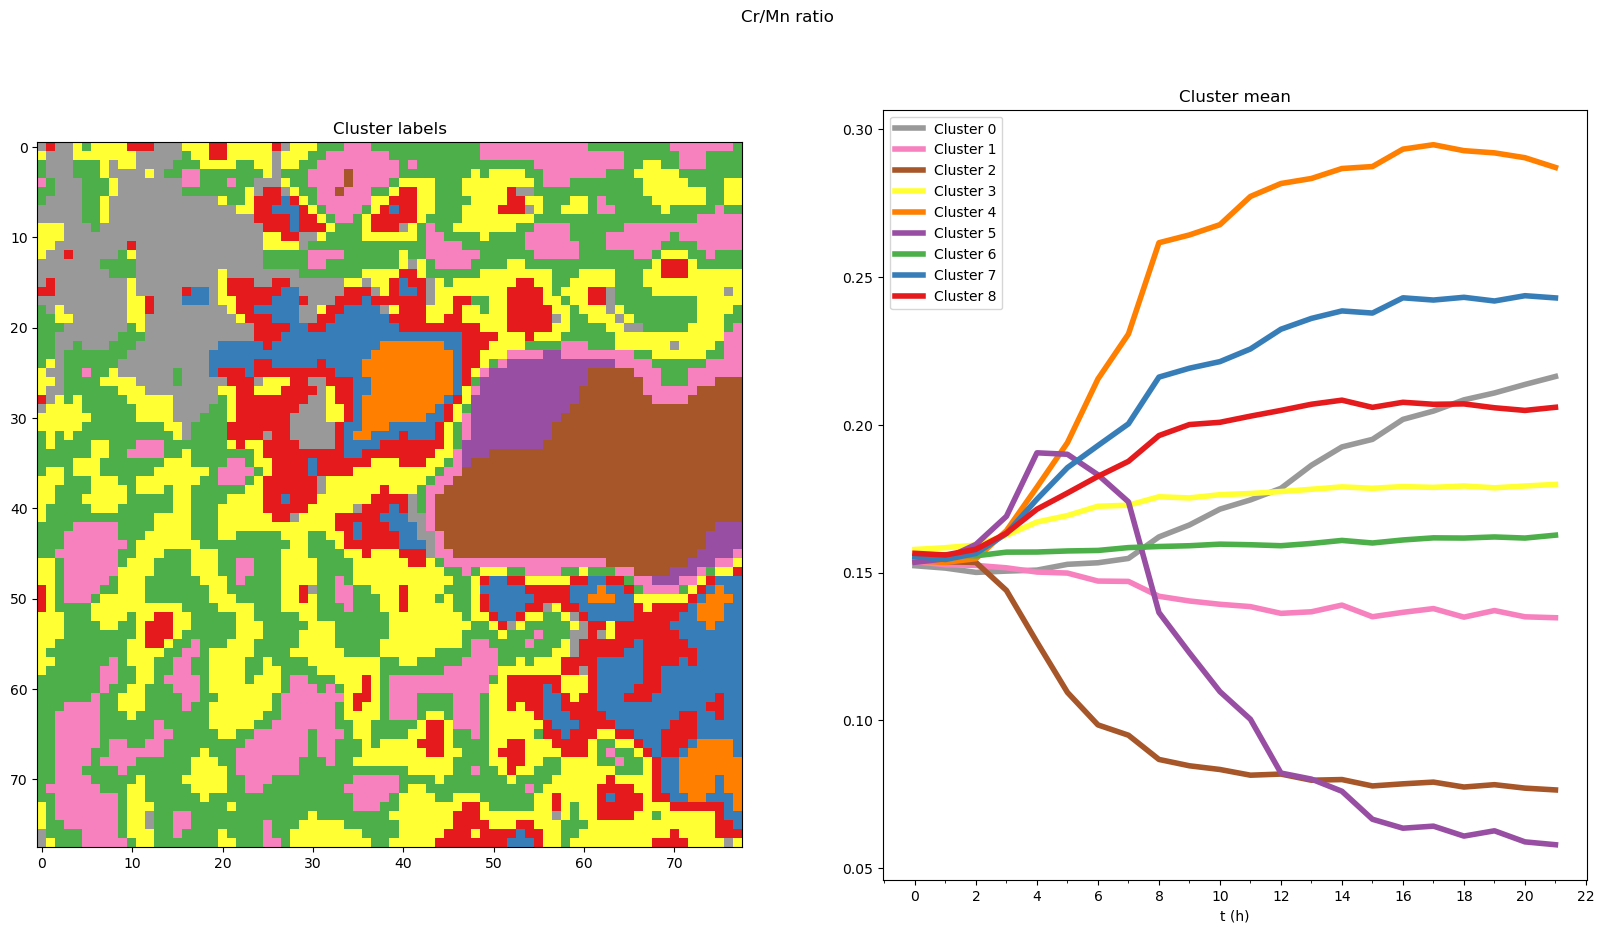

In [45]:
plot_cluster_results(Cr_Mn_cluster_model, hours, images['Cr_Ka'][0].shape, 'Cr/Mn ratio')

# Clustering Al

In [46]:
plot_pixel_time_series(hours, images['Al-Ka'], 'Al')

KeyError: 'Al-Ka'

In [ ]:
smoothed_Al = smooth_time_series(images['Al-Ka'], window_size)
n_clusters = 6
Al_cluster_model = KMeans(n_clusters=n_clusters)
Al_cluster_model.fit(smoothed_Al.T[:,window_size-1:])

KMeans(n_clusters=6)

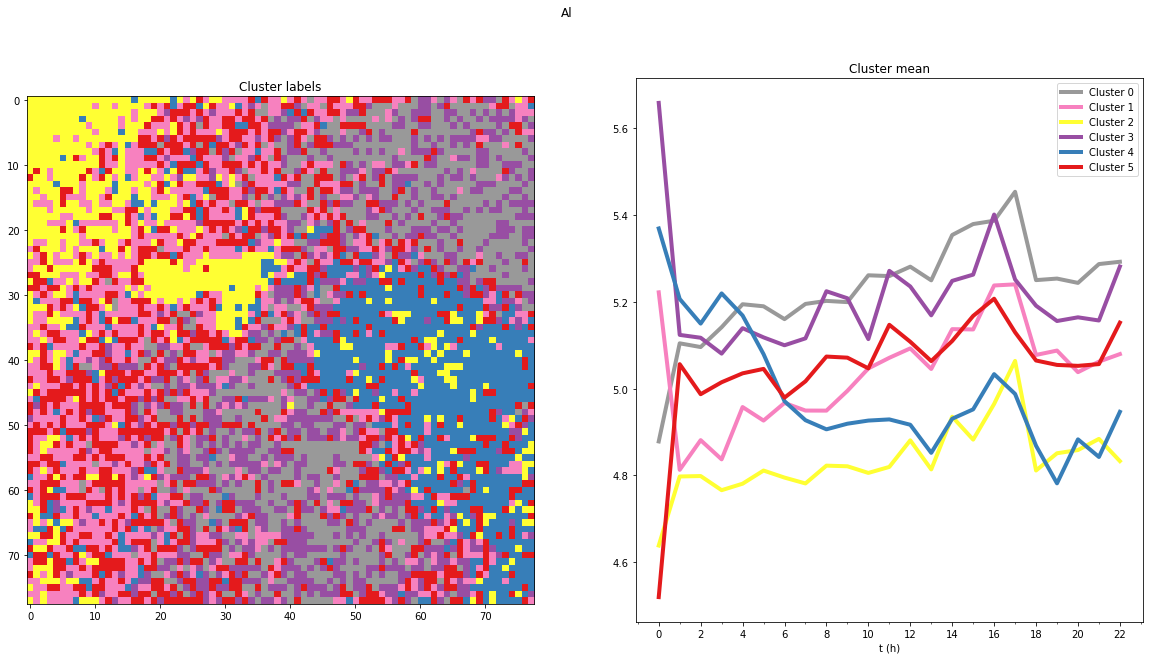

In [ ]:
plot_cluster_results(Al_cluster_model, hours, images['Al-Ka'][0].shape, 'Al')

In [47]:
def plot_cluster_collage(models, names, time, data_shape, save=False):
    from matplotlib import cm
    import matplotlib.colors as colors
    import matplotlib as mpl
    plt.rcParams['font.size'] = 14

    cmap_ = cm.Set1_r
    plt.figure(figsize=(20,20), dpi=300)
    for idx, model in enumerate(models):
        name = names[idx]

        # Define the normalization for the colormap
        norm = colors.Normalize(vmin=0, vmax=model.labels_.max())
        # Map the cluster labels to colors using the colormap and normalization
        cluster_colors = cmap_(norm(model.labels_.reshape([data_shape[0], data_shape[1]])))
    
        plt.subplot(2,2,idx+1)
        plt.imshow(cluster_colors, cmap=cmap_)
        plt.title(f'Cluster labels {name}')

        plt.subplot(2,2,idx+3)

        for idx,center in enumerate(model.cluster_centers_):
            plt.plot(hours[window_size-1:], center.T, label=f'Cluster {idx}', color=cmap_(norm(idx)), linewidth=4)
        plt.xlabel('t (h)')
        plt.ylabel('Mean intensity (a.u.)')
        plt.title(f'Cluster mean {name}')
        ax = plt.gca()
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
        
        plt.legend()
        if save:
            plt.savefig(f'figures/clustering_{names}_{scan_detail}.png', transparent=False, bbox_inches='tight', )


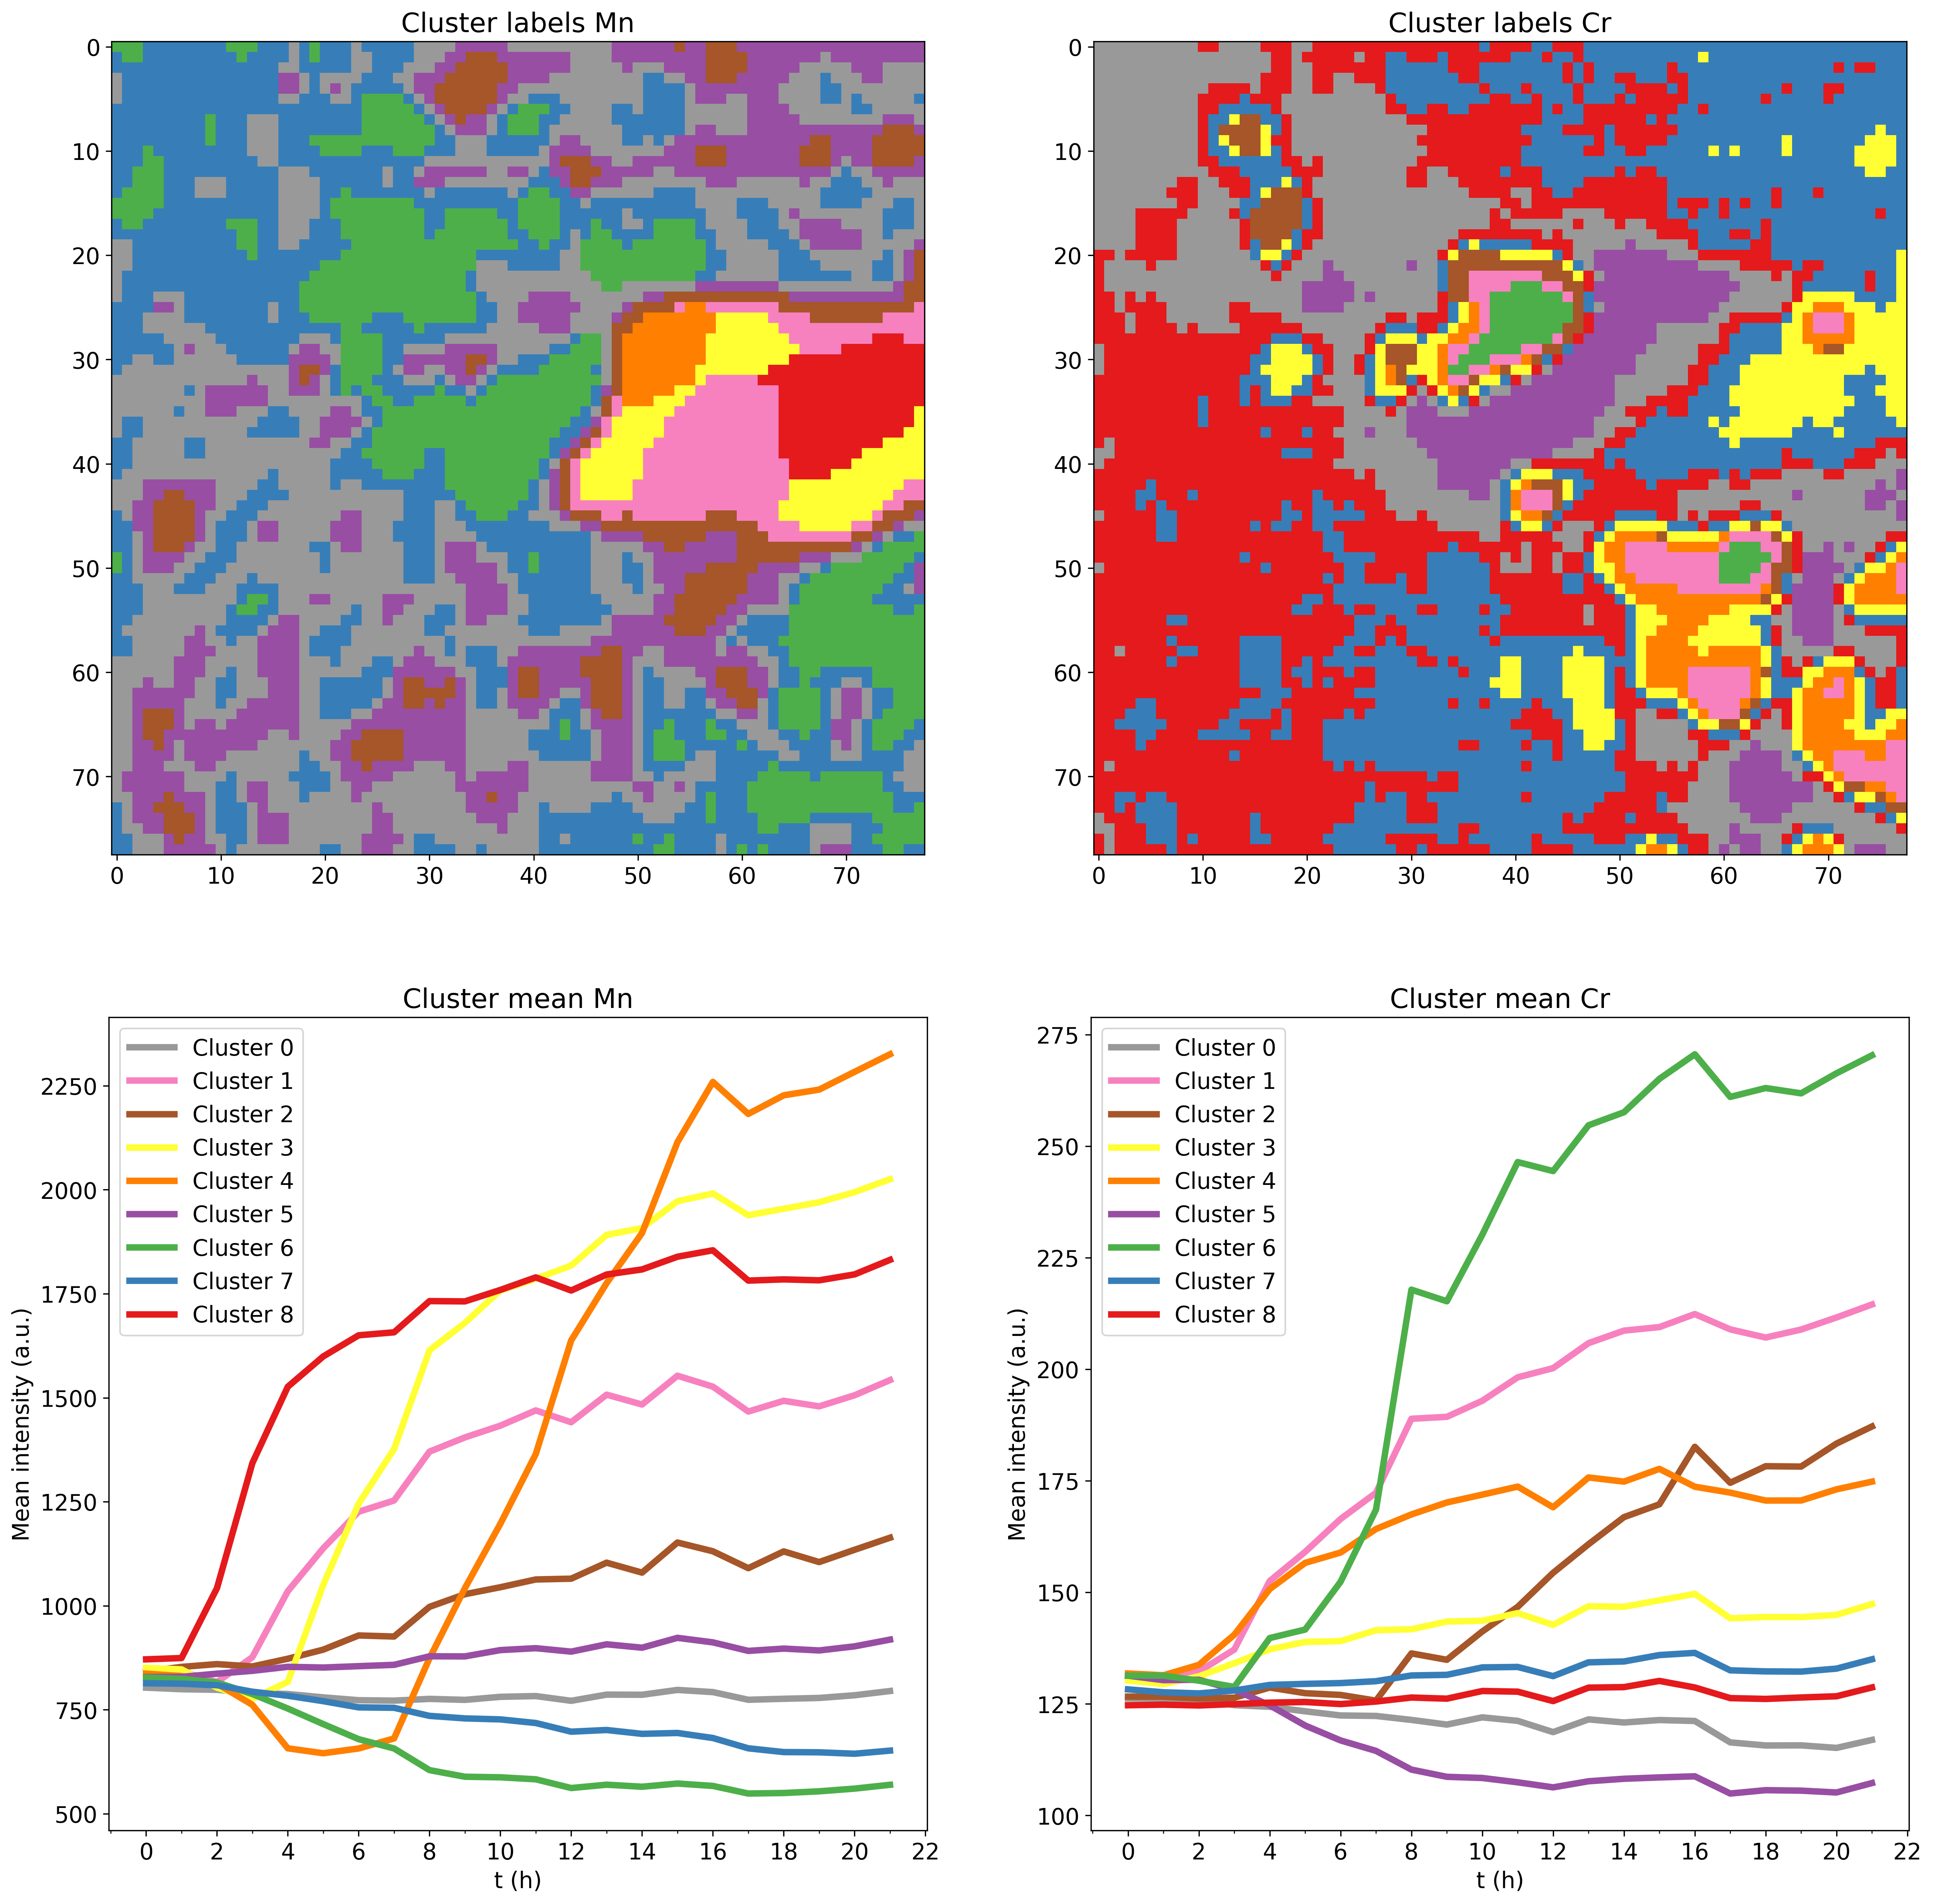

In [50]:
plot_cluster_collage([Mn_cluster_model, Cr_cluster_model], ['Mn', 'Cr'], hours, images['Mn_Ka'][0].shape, save=False)


In [ ]:
Mn_distances = Mn_cluster_model.transform(smoothed_Mn.T)

In [49]:
Mn_distances.shape

NameError: name 'Mn_distances' is not defined

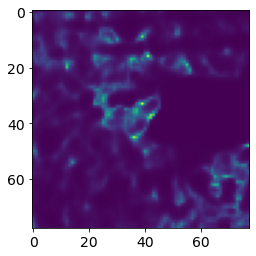

In [120]:
label = 5
weights = 1/(Mn_distances+1)**2
plt.imshow(weights[:,label].reshape(images['Mn_Ka'][0].shape))